### Regridding data to climate grid scale
[18-09-19]

In [1]:
# Libraries
%load_ext autoreload
%autoreload

import numpy as np
import iris
import pandas as pd

import sys
sys.path.append('../')
from libs.plot_maps import *


import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs

In [54]:
# Loading in the data
dir = '../data/'
files = {'cropland'     :'states.TRENDYv8.proc.crop.n96e.nc',
         'fract_agr'    :'states.TRENDYv8.proc.frac_agr.n96e.nc',
         'pasture'      :'states.TRENDYv8.proc.pastr.n96e.nc'}


input_data = {}

for key, f in files.items():
    dat = iris.load_cube(dir + f, 'area_fraction')
    input_data[key] = dat

print(input_data['cropland'])

area_fraction / (1)                 (time: 320; -- : 144; -- : 192)
     Dimension coordinates:
          time                           x         -         -
     Attributes:
          CDI: Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.6
          NCO: netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, Code = h...
          activity_id: input4MIPs
          comment: LUH2
          contact: gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.edu, ritvik@umd.ed...
          creation_date: 2016-10-12T18:26:36Z
          data_structure: grid
          frequency: yr
          further_info_url: http://luh.umd.edu
          history: Fri Jul 19 11:10:14 2019: ncrename -d lon,longitude states.TRENDYv8.proc.crop.n96e.nc
Fri...
          host: UMD College Park
          institution: University of Maryland College Park
          institution_id: UofMD
          li

Need to add in the dimension coordinates for latitude and longitude, so we're going to load in a UKESM file to pinch the lat and lon dim coords

In [55]:
template = iris.load_cube(dir + 'canopy2000-2014.nc')
print(template)

m01s03i317 / (1)                    (time: 168; latitude: 144; longitude: 192)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Auxiliary coordinates:
          forecast_period                x              -               -
     Scalar coordinates:
          forecast_reference_time: 1850-01-01 00:00:00
          pseudo_level: 151, bound=(101, 202)
     Attributes:
          Conventions: CF-1.5
          STASH: m01s03i317
          source: Data from Met Office Unified Model
          um_version: 10.9
     Cell methods:
          mean: time (1 hour)
          sum: pseudo_level


In [56]:
lat = template.coord('latitude').points
lon = template.coord('longitude').points

In [57]:
crop = input_data['cropland']

In [58]:
crop = input_data['cropland']
# Dim coord for latitude (index: 1)
coord_lat = iris.coords.DimCoord(lat, standard_name='latitude',
                                 coord_system=iris.coord_systems.GeogCS(6371229.0),var_name='latitude',
                                 units='degrees')
crop.add_dim_coord(coord_lat,1)

# Dim coord for longitude (index: 2)
coord_lon = iris.coords.DimCoord(lon, standard_name='longitude',
                                 coord_system=iris.coord_systems.GeogCS(6371229.0),var_name='longitude',
                                 units='degrees')
crop.add_dim_coord(coord_lon, 2)

print(crop)

area_fraction / (1)                 (time: 320; latitude: 144; longitude: 192)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Attributes:
          CDI: Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.6
          NCO: netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, Code = h...
          activity_id: input4MIPs
          comment: LUH2
          contact: gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.edu, ritvik@umd.ed...
          creation_date: 2016-10-12T18:26:36Z
          data_structure: grid
          frequency: yr
          further_info_url: http://luh.umd.edu
          history: Fri Jul 19 11:10:14 2019: ncrename -d lon,longitude states.

In [59]:
# Load in the mask
dir_mask = '../data/climate/'
file_mask = 'air.mon.mean.nc'
mask = iris.load_cube(dir_mask + file_mask)
m = mask.collapsed('time', iris.analysis.MEAN)

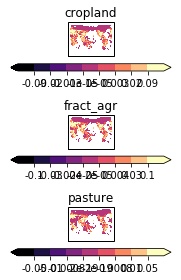

In [39]:
# Plot data to check it looks right
nd = 0

# plt.figure(figsize = (10, 7.5))

for key, dat in input_data.items():
    nd = nd + 1
    dat = dat.collapsed('time', iris.analysis.MEAN)
    dat.long_name = key
    plot_lonely_cube(dat, 3, 1, nd, cmap = 'magma', levels = None)

### Combining cubes together

In [40]:
dir_tree = '../data/treecover/'
file_tree = 'tree_cover_global.2000.tif'

tree = iris.load_cube(dir_tree  + file_tree)

ValueError: No format specification could be found for the given buffer. File element cache:
 {'UriProtocol()': 'file', 'LeadingLine()': 'b"II*\\x00\\x08\\x00\\x00\\x00\\x11\\x00\\x00\\x01\\x03\\x00\\...', 'MagicNumber(4, None)': '1229531648', 'MagicNumber(8, None)': '5280798217691201536', 'FileExtension()': '.tif', 'MagicNumber(100, None)': "b'II*\\x00\\x08\\x00\\x00\\x00\\x11\\x00\\x00\\x01\\x03\\x00\\..."}

### Regridding all variables

In [60]:
m_cropland = input_data['cropland'].regrid(m, iris.analysis.Linear())

ValueError: The rectilinear grid coordinates of the given cube and target grid must either both have coordinate systems or both have no coordinate system but with matching coordinate metadata.

In [47]:
remasked_data = {}

for key in input_data.keys():
    dat = input_data[key].regrid(m, iris.analysis.Linear())
    remasked_data[key] = dat 

ValueError: Cube 'area_fraction' must contain a single 1D x coordinate.

Saving the data

In [ ]:
for key, dat in remasked_data.items():
    new_file_names = key + "_masked.nc"
    out = '../data/land_use/' + new_file_names
    print(new_file_names)
#     iris.save(dat, out)